# Third exercice: 1D Cartesian structured VDS along  parallel lines

In this notebook, we perform pseudo-random variable density sampling along the phase encoding direction. 
A handcrafted density is designed and samples are then drawn by virtually inverting its cumulative density function. Then these samples define the selected phase encoding lines retained in the sampling mask. Low frequencies are more sampled than higher frequencies. 

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging **

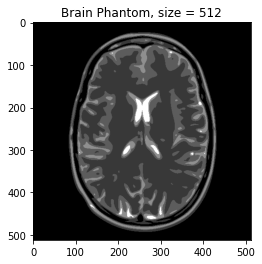

In [3]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters
#get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd, "..", "data")
img_size = 512   #256
FOV = 0.2 #field of view in meters
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

128
[255 255 256 132 255 263 134 365 197 255 296 222 254 256 278 255 268 251
 247   6 350 176 255 255 150  69 292  92 263 274 255 255 262 231 287 255
 305 196 259 170 255 291 254 160 287 255 255 255 253 246 255 189 166 238
 243 250 118 421 223 255 255 260 116 353 254 256 255 149 255 255 425 257
 220 215 196 255 255 255 255 236 255 257 327 255 319 288  48 239 255 261
 243 241 479 273 237 250 258 255 193 268 253 255 255 254 249 269 258 255
 255 252 240 252 264 150 258 253 260 246 260 259 188 253 253 277 219 258
 256 278]


<Figure size 432x288 with 0 Axes>

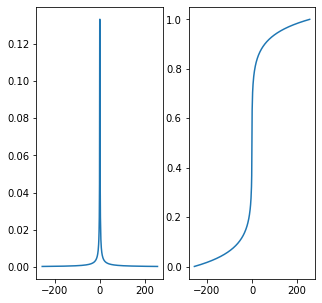

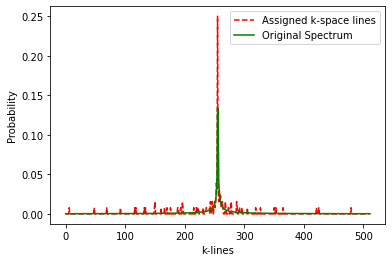

[  6  48  69  92 116 118 132 134 149 150 160 166 170 176 188 189 193 196
 197 215 219 220 222 223 231 236 237 238 239 240 241 243 246 247 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 268 269 273 274
 277 278 287 288 291 292 296 305 319 327 350 353 365 421 425 479]
70


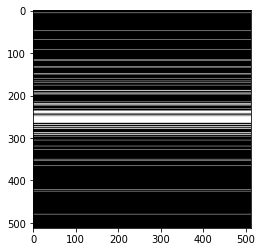

In [4]:
import numpy as np
import sys
import numpy.random as ra

eps = sys.float_info.epsilon
#img_size = 512
# generate Cartesian lines in a straightforward manner
#a = np.linspace(0,img_size,img_size)
#a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
 

c = np.ones((1, img_size), dtype="float64")
kspace_mask = np.tile(c, (img_size, 1))
#kspace_lines = np.linspace(-1/2., 1/2.,img_size)
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
# define the taret sampling density (ie non-iniform over k-space lines)
decay = 1.
# Define the sampling density
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)


pmax = p_decay.max()
pmin = p_decay.min()

# Plot the density and its cumulative distribution function (CDF) p_decay
plt.figure()
fig, axs = plt.subplots(1, 2, figsize= (5,5) )
axs[0].plot(kspace_lines, p_decay)
axs[1].plot(kspace_lines, cdf_pdecay)

# Perform pseudo-random sampling: technique used:
# draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = (int)(img_size/4)
print(nb_samples)
samples = ra.uniform(0, 1, nb_samples)
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]

# shift the samples lines by half of the k-space (ie image size as we're in Cartesian ref)
gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int) + (int)(img_size/2)
#gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int)
print(gen_klinesb)   # unsorted samples
times = np.arange(1, img_size, 1)
lc = np.bincount(gen_klinesb, minlength=len(times))

# check that histogram of sample values fits the prescribed density p_decay
plt.figure()
plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()


#print(p_decay.min())
sampled_klines = np.array(np.unique(gen_klinesb))
print(sampled_klines)

nblines = np.size(sampled_klines)
print(nblines)
threshold = 2. * p_decay.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")

plt.figure()
plt.imshow(kspace_mask, cmap='gray')
plt.show()


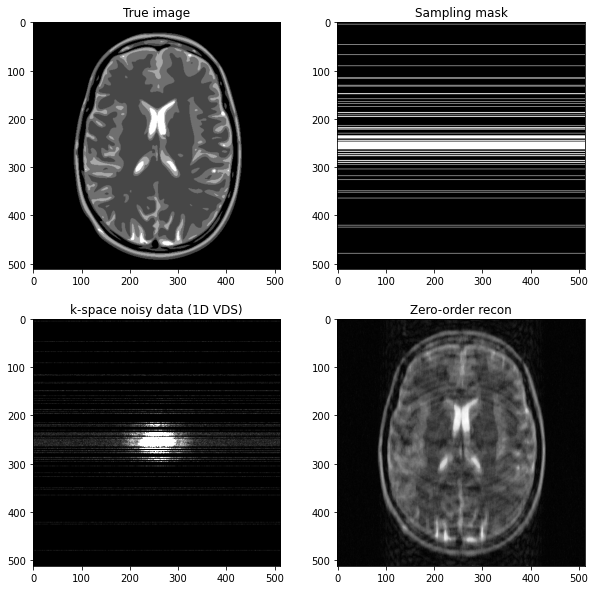

In [5]:
#import numpy.fft as fft
norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)


# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
#kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Simulate independent noise realization on the real & imag parts
kspace_data += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise 

# Mask data to perform subsampling
kspace_data *= kspace_mask 

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='gray')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.005*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (1D VDS)")
axs[1,1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()
